In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

# Commonly used modules
import warnings
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib
import matplotlib.animation as animation
from IPython.display import HTML
import textwrap
import statsmodels.formula.api as smf

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler



warnings.filterwarnings("ignore")

In [4]:
# Load in the cleaned/normalized dataset

combined_data = pd.read_csv("/content/drive/MyDrive/ENEE408N/Sleep Analysis Research/DATA_SETS/test2.csv")
combined_data.head()

,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,...,circadian_cosine,circadian_decay,circadian_linear,Sleep_Stage,Obstructive_Apnea,Central_Apnea,Hypopnea,Multiple_Events,artifact,sid
0,0.215679,0.516293,0.499829,0.448541,0.445365,0.628456,0.563598,0.361111,0.266667,0.341628,...,0.792550,1.000000,0.000000,0,0.0,0.0,0.0,0.0,1.0,S002
1,0.656957,0.157949,0.098599,0.099325,0.097596,0.195178,0.196617,0.361111,0.506667,0.647154,...,0.794376,0.995443,0.001348,0,0.0,0.0,0.0,0.0,1.0,S002
2,0.638216,0.148870,0.073967,0.072398,0.071112,0.148628,0.145472,0.398148,0.320000,0.395054,...,0.796195,0.990907,0.002695,0,0.0,0.0,0.0,0.0,0.0,S002
3,0.699413,0.116102,0.072649,0.072891,0.071499,0.154617,0.155133,0.250000,0.253333,0.365007,...,0.798007,0.986390,0.004043,0,0.0,0.0,0.0,0.0,0.0,S002
4,0.680527,0.130083,0.067667,0.059069,0.057890,0.140486,0.122657,0.324074,0.240000,0.319592,...,0.799812,0.981893,0.005391,0,0.0,0.0,0.0,0.0,1.0,S002


In [5]:
#Batch data

print(combined_data["sid"].shape)
counter = 0
batched = []
sid = ""
split_start = 0

for i in range(len(combined_data["sid"])):
  curr_sid = combined_data["sid"][i]
  if curr_sid != sid:
    sid = curr_sid
    counter = 0
  elif combined_data["sid"][i] == "S095" and split_start == 0:
    split_start = len(batched)
    counter = 0
    print(split_start)
  elif counter ==120:
    for j in range(120):
      batched.append(combined_data.iloc[i-120+j])
    counter = 0
  else:
    counter += 1


combined_data = pd.DataFrame(batched)
print(combined_data.shape)

(80190,)
65760
(72360, 134)


In [6]:
#get x and y/training and testing
#101698
#71265
X = combined_data.drop("Sleep_Stage", axis=1).drop("sid", axis=1)
y = combined_data["Sleep_Stage"]

#split data into test and training data
x_train = X[0:split_start]
x_test = X[split_start:]
y_train = y[0:split_start]
y_test = y[split_start:]



train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
train_features = (x_train - train_mean) / train_std

In [7]:
#implement 1 hot for 0-4 classifying
def one_hot(input):
  input = input.astype(int)
  arr = np.eye(5)[input]
  return arr


#use 1 hot func
y_train = one_hot(y_train)
y_test = one_hot(y_test)
print(y_train.shape)
print(y_test.shape)

print(y_train[0])

(65760, 5)
(6600, 5)
[1. 0. 0. 0. 0.]


In [12]:
#Build

def reverse_one_hot(input):
  arr = np.argmax(input, axis=1)
  return arr


class Cohen_Kappa_Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(x_test, verbose=0)
        print(y_pred.shape)
        prediction = []
        index = 0
        max = 0
        for i in range(len(y_pred)):
          for j in range(5):
            if y_pred[i][j]>max:
              max = y_pred[i][j]
              index = j
          prediction.append(index)
          max = 0
        prediction = np.array(prediction)
        y2 = reverse_one_hot(y_test)

        print(prediction[:5])
        print(y2[:5])
        kappa = cohen_kappa_score(y2,prediction)

        print(f"Epoch {epoch + 1}: Cohen Kappa = {kappa:.4f}")


def build_model():
    num_features = 132
    time_steps = 84716
    num_classes = 5

    model = keras.Sequential([
      SimpleRNN(32, input_shape=(num_features,1)),
      Dense(10, activation=tf.nn.relu),
      Dense(num_classes, activation='softmax')
    ])


    model.compile(optimizer=tf.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['mse',"binary_accuracy", "f1_score"])
    return model


# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0: print('')
        print('.', end='')

model = build_model()
v_split = 1-(split_start/len(combined_data))
print(v_split)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, epochs=3, batch_size = 120, verbose=0, validation_split = 0.11129816685372242, callbacks=[early_stop, PrintDot(), Cohen_Kappa_Callback()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


0.09121061359867333

.(6600, 5)
[0 0 0 0 3]
[0 0 0 0 0]
Epoch 1: Cohen Kappa = 0.0310
.(6600, 5)
[3 3 3 3 3]
[0 0 0 0 0]
Epoch 2: Cohen Kappa = 0.0098
.(6600, 5)
[0 0 0 0 0]
[0 0 0 0 0]
Epoch 3: Cohen Kappa = 0.0662


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - binary_accuracy: 0.7843 - f1_score: 0.1383 - loss: 1.5046 - mse: 0.1547

Final Root Mean Square Error on validation set: 0.382


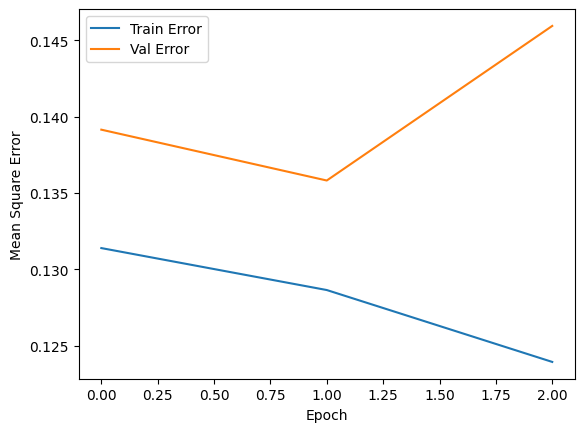

In [14]:
#Get Metrics
test_features_norm = (x_test - train_mean) / train_std
loss, mse, accuracy, f1_score = model.evaluate(test_features_norm, y_test)

rmse_final = np.sqrt(float(hist['val_mse'].iloc[-1]))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

#Plot MSE
def plot_mse():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_mse()

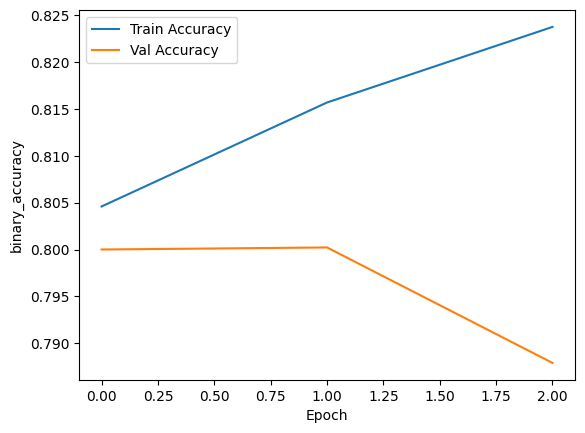

In [16]:
#Plot binary accuracy
def plot_accuracy():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('binary_accuracy')
    plt.plot(hist['epoch'], hist['binary_accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_binary_accuracy'], label = 'Val Accuracy')
    plt.legend()

plot_accuracy()

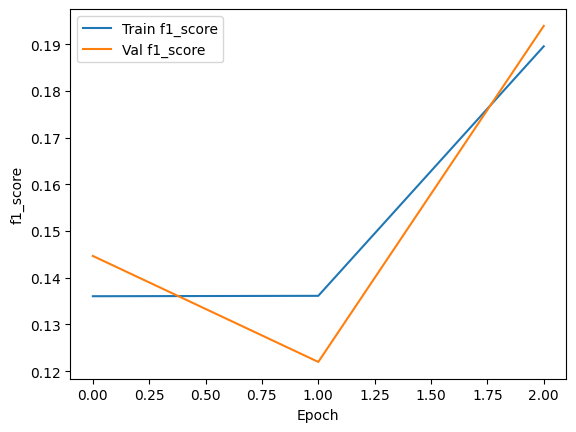

In [20]:
#Plot f1_score
def plot_f1_score():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('f1_score')
    f1_score_train = np.array([np.mean(x) for x in hist['f1_score']])
    f1_score_val = np.array([np.mean(x) for x in hist['val_f1_score']])
    plt.plot(hist['epoch'], f1_score_train, label='Train f1_score')
    plt.plot(hist['epoch'], f1_score_val, label = 'Val f1_score')
    plt.legend()

plot_f1_score()